# **Exploratory Data Analysis**

In [2]:
from __future__ import annotations

import math
from pathlib import Path

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

In [4]:
import matplotlib
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
DATA_PATH = Path("/content/drive/MyDrive/MLOpsFinal/raw data.csv")
assert DATA_PATH.exists(), f"CSV not found: {DATA_PATH}"

raw_df = pd.read_csv(DATA_PATH, low_memory=False)
df = raw_df.loc[raw_df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
df["loan_status"] = pd.Categorical(df["loan_status"], categories=["Fully Paid", "Charged Off"], ordered=True)

print(f"Total rows: {len(raw_df):,}")
print(f"Columns: {len(df.columns)}")
df.head()

Total rows: 1,345,310
Columns: 151


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


The original Lending Club dataset contains 151 features describing loan applications, borrower credit history, financial indicators, and loan performance outcomes. These variables include numeric fields (interest rate, loan amount, FICO score), categorical descriptors (grade, home ownership, employment length) and several date-formatted columns.

# **Data cleaning**

In [7]:
leakage_cols = [
    "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_amnt", "last_pymnt_d", "last_credit_pull_d",
    "out_prncp", "out_prncp_inv", "next_pymnt_d",
    "settlement_amount", "settlement_date", "settlement_status",
    "settlement_percentage", "settlement_term",
    "orig_projected_additional_accrued_interest"
]

print("=== Leakage features: availability by loan_status ===")
for col in leakage_cols:
    if col in df.columns:
        tmp = df.groupby("loan_status")[col].apply(
            lambda s: {"non_null_pct": s.notna().mean()*100,
                       "mean": getattr(s, "mean", lambda: None)() if s.dtype != "O" else None}
        )
        print(col, "->", tmp.to_dict())


=== Leakage features: availability by loan_status ===
total_pymnt -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 16453.24434059925, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 8291.083571114985}
total_pymnt_inv -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 16427.102299853916, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 8277.379175153319}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(


total_rec_prncp -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 14125.849706515248, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 4387.877516113778}
total_rec_int -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 2326.569790620117, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 2689.126532195905}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(


total_rec_late_fee -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 0.8248451496947701, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 4.622595616837871}
recoveries -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 0.0, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 1209.456925835154}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(


collection_recovery_fee -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 0.0, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 201.52624297857108}
last_pymnt_amnt -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 6658.467295638156, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 472.4203663564242}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmp = df.groupby("loan_status

last_pymnt_d -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): nan, ('Charged Off', 'non_null_pct'): 99.13873673941293, ('Charged Off', 'mean'): nan}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status

last_credit_pull_d -> {('Fully Paid', 'non_null_pct'): 99.9958207607887, ('Fully Paid', 'mean'): nan, ('Charged Off', 'non_null_pct'): 99.99627642343023, ('Charged Off', 'mean'): nan}
out_prncp -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 0.0, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 0.0}
out_prncp_inv -> {('Fully Paid', 'non_null_pct'): 100.0, ('Fully Paid', 'mean'): 0.0, ('Charged Off', 'non_null_pct'): 100.0, ('Charged Off', 'mean'): 0.0}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(


next_pymnt_d -> {('Fully Paid', 'non_null_pct'): 0.0, ('Fully Paid', 'mean'): nan, ('Charged Off', 'non_null_pct'): 0.0, ('Charged Off', 'mean'): nan}
settlement_amount -> {('Fully Paid', 'non_null_pct'): 0.00046435991236599733, ('Fully Paid', 'mean'): 4179.508, ('Charged Off', 'non_null_pct'): 12.388711605271094, ('Charged Off', 'mean'): 5030.061219380239}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmp = df.groupby("loan_status

settlement_date -> {('Fully Paid', 'non_null_pct'): 0.00046435991236599733, ('Fully Paid', 'mean'): nan, ('Charged Off', 'non_null_pct'): 12.388711605271094, ('Charged Off', 'mean'): nan}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(
/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status

settlement_status -> {('Fully Paid', 'non_null_pct'): 0.00046435991236599733, ('Fully Paid', 'mean'): nan, ('Charged Off', 'non_null_pct'): 12.388711605271094, ('Charged Off', 'mean'): nan}
settlement_percentage -> {('Fully Paid', 'non_null_pct'): 0.00046435991236599733, ('Fully Paid', 'mean'): 52.007999999999996, ('Charged Off', 'non_null_pct'): 12.388711605271094, ('Charged Off', 'mean'): 47.691059481229885}
settlement_term -> {('Fully Paid', 'non_null_pct'): 0.00046435991236599733, ('Fully Paid', 'mean'): 6.6, ('Charged Off', 'non_null_pct'): 12.388711605271094, ('Charged Off', 'mean'): 13.15911754981816}
orig_projected_additional_accrued_interest -> {('Fully Paid', 'non_null_pct'): 0.14878091592206555, ('Fully Paid', 'mean'): 339.22198501872657, ('Charged Off', 'non_null_pct'): 0.803175466098697, ('Charged Off', 'mean'): 463.7807371349095}


/tmp/ipython-input-1670687183.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby("loan_status")[col].apply(


# **Feature removal justification**

In [8]:
from sklearn.preprocessing import LabelEncoder

leakage_numeric = [
    c for c in leakage_cols
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
]

df["is_default"] = (df["loan_status"] == "Charged Off").astype(int)

corr_with_target = df[leakage_numeric].corrwith(df["is_default"]).sort_values(key=lambda x: abs(x), ascending=False)
print("Correlation of leakage features with default:")
print(corr_with_target)


Correlation of leakage features with default:
recoveries                                    0.505415
collection_recovery_fee                       0.480216
total_rec_prncp                              -0.438944
last_pymnt_amnt                              -0.347385
total_pymnt                                  -0.315180
total_pymnt_inv                              -0.314751
orig_projected_additional_accrued_interest    0.172316
total_rec_late_fee                            0.141032
total_rec_int                                 0.055718
settlement_term                               0.009762
settlement_percentage                        -0.007242
settlement_amount                             0.002829
out_prncp                                          NaN
out_prncp_inv                                      NaN
next_pymnt_d                                       NaN
dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


| Feature                                        | Corr w/ Default              | Meaning                                         | Why It's Leakage                                                             |
| ---------------------------------------------- | ---------------------------- | ----------------------------------------------- | ---------------------------------------------------------------------------- |
| **recoveries**                                 | **+0.505**                   | Recoveries happen *only after a loan defaults*. | Directly reveals that the loan defaulted.                                    |
| **collection_recovery_fee**                    | **+0.48**                    | Fees charged during collections process.        | Only occurs after charge-off → future info.                                  |
| **total_rec_prncp**                            | **–0.44**                    | Principal repaid.                               | Fully paid loans repay high principal → negative signal.                     |
| **last_pymnt_amnt**                            | –0.35                        | Amount of borrower’s final payment.             | Requires knowing repayment history.                                          |
| **total_pymnt / total_pymnt_inv**              | ≈ –0.31                      | Total amount repaid.                            | Fully paid loans repay more → reveals outcome.                               |
| **orig_projected_additional_accrued_interest** | +0.17                        | Calculated over life of loan.                   | Not available at origination; depends on repayment pattern.                  |
| **total_rec_late_fee**                         | +0.14                        | Late fees only accumulate during delinquency.   | Tells you borrower struggled → leakage.                                      |
| **total_rec_int**                              | +0.05                        | Interest paid over loan life.                   | Depends on whether loan was fully completed.                                 |
| **settlement_* fields**                        | near 0 but **still leakage** | Settlement happens only during default.         | Even if correlation is small, these values **exist only for default loans**. |

Therefore these columns were removed due to high data leakage.

=== Missing percentage for joint / secondary applicant fields ===
sec_app_revol_util           98.639570
revol_bal_joint              98.615263
sec_app_open_act_il          98.615189
sec_app_earliest_cr_line     98.615189
sec_app_open_acc             98.615189
sec_app_mort_acc             98.615189
sec_app_num_rev_accts        98.615189
verification_status_joint    98.097465
dti_joint                    98.082449
annual_inc_joint             98.082226
dtype: float64


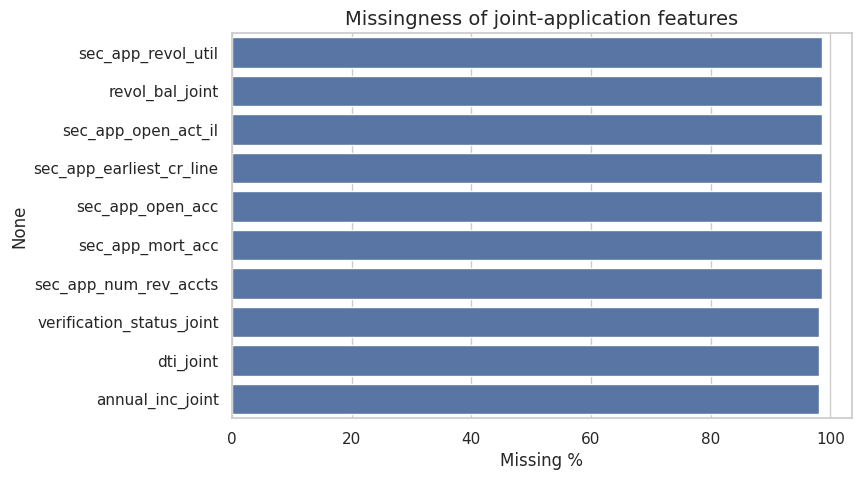

In [9]:
joint_cols = [
    "verification_status_joint", "annual_inc_joint", "dti_joint", "revol_bal_joint",
    "sec_app_open_acc", "sec_app_revol_util", "sec_app_mort_acc",
    "sec_app_earliest_cr_line", "sec_app_open_act_il",
    "sec_app_num_rev_accts", "sec_app_inc_last_6mths"
]

joint_cols = [c for c in joint_cols if c in df.columns]

missing_joint = df[joint_cols].isna().mean().sort_values(ascending=False)*100
print("=== Missing percentage for joint / secondary applicant fields ===")
print(missing_joint)

plt.figure(figsize=(8,5))
sns.barplot(x=missing_joint.values, y=missing_joint.index)
plt.xlabel("Missing %")
plt.title("Missingness of joint-application features")
plt.show()


As shown in the chart, all joint-application fields are over 98% missing. Because they apply only to a tiny minority of loans, they introduce noise, duplicate existing information and would cause the model to break in production. That's why we removed these features.

In [10]:
admin_cols = [c for c in ["policy_code", "zip_code"] if c in df.columns]

print("=== Basic stats for administrative fields ===")
for col in admin_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].nunique())
    print(df[col].value_counts().head())


=== Basic stats for administrative fields ===

Column: policy_code
Unique values: 1
policy_code
1.0    1345310
Name: count, dtype: int64

Column: zip_code
Unique values: 943
zip_code
945xx    15005
750xx    14474
112xx    13829
606xx    12433
300xx    12124
Name: count, dtype: int64


The variable policy_code is always constant and the variable zip_code has very high cardinality and limited signal. So we removed them from the analysis.


In [11]:
text_cols = [c for c in ["url", "title", "desc"] if c in df.columns]

print("=== Text / metadata fields ===")
for col in text_cols:
    print(f"\nColumn: {col}")
    print("dtype:", df[col].dtype)
    print("Missing %:", df[col].isna().mean()*100)
    print("Example values:")
    print(df[col].dropna().head(3).tolist())


=== Text / metadata fields ===

Column: url
dtype: object
Missing %: 0.0
Example values:
['https://lendingclub.com/browse/loanDetail.action?loan_id=68407277', 'https://lendingclub.com/browse/loanDetail.action?loan_id=68355089', 'https://lendingclub.com/browse/loanDetail.action?loan_id=68341763']

Column: title
dtype: object
Missing %: 1.2383762850198095
Example values:
['Debt consolidation', 'Business', 'Major purchase']

Column: desc
dtype: object
Missing %: 90.8177297425872
Example values:
['We knew that using our credit cards to finance an adoption would squeeze us, but then medical and other unexpected expenses made the situation almost impossible. We are a stable family in a stable community. We just need to break a cycle of debt that is getting worse.', "I had a bad year two years ago, with some late and missed payments. I'm doing much better now, but I've got fees and some higher interest bits that have added up on top of the other stuff, and it's a little crazy. I'm hoping doin

URL was removed because it has no predictive value, it contains no information about the borrower or the loan’s credit risk. It adds noise and increases dimensionality without improving accuracy.

The variable title was removed because borrowers manually type this field, so it is inconsistent, noisy and unstructured. In most cases it duplicates the structured feature purpose, which already classifies the loan reason cleanly.

The variable description does not add any value to the analysis. Therefore, we  removed this feature.

In [12]:
leakage_features = [
    "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_amnt", "last_pymnt_d", "last_credit_pull_d",
    "out_prncp", "out_prncp_inv", "next_pymnt_d",
    "settlement_amount", "settlement_date", "settlement_status",
    "settlement_percentage", "settlement_term",
    "orig_projected_additional_accrued_interest"
]

joint_app_features = [
    "verification_status_joint", "annual_inc_joint", "dti_joint",
    "revol_bal_joint", "sec_app_open_acc", "sec_app_revol_util",
    "sec_app_mort_acc", "sec_app_earliest_cr_line", "sec_app_open_act_il",
    "sec_app_num_rev_accts", "sec_app_inc_last_6mths"
]

administrative_features = [
    "policy_code",
    "zip_code"
]

text_metadata_features = [
    "url", "title", "desc"
]


all_remove_cols = (
    leakage_features
    + joint_app_features
    + administrative_features
    + text_metadata_features
)

# dropping columns.

cols_to_drop = [col for col in all_remove_cols if col in df.columns]

df_clean = df.drop(columns=cols_to_drop)

print("Removed columns:")
print(cols_to_drop)
print("\nShape before:", df.shape)
print("Shape after:", df_clean.shape)


Removed columns:
['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d', 'last_credit_pull_d', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d', 'settlement_amount', 'settlement_date', 'settlement_status', 'settlement_percentage', 'settlement_term', 'orig_projected_additional_accrued_interest', 'verification_status_joint', 'annual_inc_joint', 'dti_joint', 'revol_bal_joint', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_mort_acc', 'sec_app_earliest_cr_line', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'policy_code', 'zip_code', 'url', 'title', 'desc']

Shape before: (1345310, 152)
Shape after: (1345310, 118)


# **Feature engineering**

In [13]:
def percent_to_float(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        return series
    return pd.to_numeric(series.astype(str).str.rstrip("%"), errors="coerce")


def strip_non_numeric(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        return series
    cleaned = series.astype(str).str.replace(",", "", regex=False)
    cleaned = cleaned.str.replace(" ", "", regex=False)
    return pd.to_numeric(cleaned, errors="coerce")


def normalize_term(value: str) -> str | None:
    if pd.isna(value):
        return None
    digits = "".join(ch for ch in str(value) if ch.isdigit())
    return digits or None


def normalize_emp_length(value: str) -> str | None:
    if pd.isna(value):
        return None
    value = value.strip().lower()
    if value in {"", "nan"}:
        return None
    if value.startswith("<"):
        return "< 1 year"
    if value.startswith("10"):
        return "10+ years"
    if "n/a" in value:
        return "n/a"
    for yr in range(1, 10):
        if value.startswith(str(yr)):
            return f"{yr} years"
    return value.title()


def default_rate_table(frame: pd.DataFrame, column: str, min_count: int = 1) -> pd.DataFrame:
    temp = frame.dropna(subset=[column])
    grouped = temp.groupby(column)["is_default"].agg(["count", "mean"]).rename(columns={"mean": "default_pct"})
    grouped = grouped[grouped["count"] >= min_count].copy()
    grouped["default_pct"] = (grouped["default_pct"] * 100).round(2)
    return grouped.sort_values("default_pct", ascending=False)


percent_columns = ["int_rate", "revol_util"]
for col in percent_columns:
    if col in df.columns:
        df[f"{col}_num"] = percent_to_float(df[col])

fico_cols = ["fico_range_low", "fico_range_high"]
if set(fico_cols).issubset(df.columns):
    df[fico_cols] = df[fico_cols].apply(strip_non_numeric)
    df["fico_score"] = df[fico_cols].mean(axis=1)

if "term" in df.columns:
    df["term_clean"] = df["term"].map(normalize_term)

if "emp_length" in df.columns:
    df["emp_length_clean"] = df["emp_length"].map(normalize_emp_length)

numeric_candidates = [
    "loan_amnt", "funded_amnt", "funded_amnt_inv", "installment", "annual_inc",
    "dti", "delinq_2yrs", "inq_last_6mths", "mths_since_last_delinq", "open_acc",
    "pub_rec", "revol_bal", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "recoveries",
    "collection_recovery_fee", "last_pymnt_amnt", "tot_cur_bal", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util",
    "total_rev_hi_lim", "avg_cur_bal", "bc_util", "num_actv_bc_tl", "num_actv_rev_tl",
    "num_bc_tl", "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit"
]
for col in set(numeric_candidates).intersection(df.columns):
    df[col] = strip_non_numeric(df[col])

if "revol_util_num" not in df.columns and "revol_util" in df.columns:
    df["revol_util_num"] = percent_to_float(df["revol_util"])

df["is_default"] = (df["loan_status"] == "Charged Off").astype(int)

print("Derived columns added:", sorted(set(df.columns) - set(raw_df.columns)))

Derived columns added: ['emp_length_clean', 'fico_score', 'int_rate_num', 'is_default', 'revol_util_num', 'term_clean']


In [14]:
numeric_df = df.select_dtypes(include=[np.number]).copy()
numeric_df = numeric_df.loc[:, numeric_df.notna().any(axis=0)]
sample_n = min(200000, len(numeric_df))
numeric_sample = numeric_df.sample(n=sample_n, random_state=42) if len(numeric_df) > sample_n else numeric_df
print(f"Numeric columns: {numeric_df.shape[1]}")
print(f"Numeric sample size for heavy calcs: {len(numeric_sample):,}")
numeric_sample.describe().T.head(10)

Numeric columns: 117
Numeric sample size for heavy calcs: 200,000


,count,mean,std,min,25%,50%,75%,max
id,200000.0,5.630314e+07,3.837709e+07,65104.00,1.992767e+07,57722853.00,84573339.50,1.456135e+08
loan_amnt,200000.0,1.442501e+04,8.725748e+03,500.00,8.000000e+03,12000.00,20000.00,4.000000e+04
funded_amnt,200000.0,1.441545e+04,8.721580e+03,500.00,8.000000e+03,12000.00,20000.00,4.000000e+04
funded_amnt_inv,200000.0,1.439366e+04,8.724198e+03,0.00,7.900000e+03,12000.00,20000.00,4.000000e+04
int_rate,200000.0,1.324160e+01,4.774567e+00,5.31,9.750000e+00,12.74,15.99,3.099000e+01
installment,200000.0,4.382571e+02,2.614547e+02,15.69,2.488200e+02,374.33,581.58,1.719830e+03
annual_inc,200000.0,7.615587e+04,6.788827e+04,0.00,4.574219e+04,65000.00,90000.00,8.400000e+06
dti,199948.0,1.828250e+01,1.117532e+01,0.00,1.182000e+01,17.63,24.01,9.990000e+02
delinq_2yrs,200000.0,3.152800e-01,8.737805e-01,0.00,0.000000e+00,0.00,0.00,2.600000e+01
fico_range_low,200000.0,6.961531e+02,3.182384e+01,660.00,6.700000e+02,690.00,710.00,8.450000e+02


In [15]:
date_info = []
date_columns = [col for col in df.columns if col.endswith('_d') or col.endswith('_date')]

for col in date_columns:
    if col not in df.columns:
        date_info.append({
            'Column Name': col,
            'Min Date': pd.NaT,
            'Max Date': pd.NaT,
            'Remarks': 'Column not found'
        })
        continue

    df[col] = pd.to_datetime(df[col], errors='coerce', format='%b-%Y')

    if not df[col].isnull().all():
        min_date = df[col].min()
        max_date = df[col].max()
        date_info.append({
            'Column name': col,
            'Min date': min_date,
            'Max date': max_date,
            'Remarks': ''
        })
    else:
        date_info.append({
            'Column name': col,
            'Min date': pd.NaT,
            'Max date': pd.NaT,
            'Remarks': 'No valid dates or entirely missing'
        })

date_ranges_df = pd.DataFrame(date_info)
print("Date ranges in the data:")
display(date_ranges_df)

Date ranges in the data:


,Column name,Min date,Max date,Remarks
0,issue_d,2007-06-01,2018-12-01,
1,last_pymnt_d,2008-01-01,2019-03-01,
2,next_pymnt_d,NaT,NaT,No valid dates or entirely missing
3,last_credit_pull_d,2007-05-01,2019-04-01,
4,hardship_start_date,2017-01-01,2019-02-01,
5,hardship_end_date,2017-03-01,2019-03-01,
6,payment_plan_start_date,2017-02-01,2019-02-01,
7,debt_settlement_flag_date,2010-02-01,2019-03-01,
8,settlement_date,2010-02-01,2019-03-01,


# **Target variable distribution**

,count,percentage
loan_status,,
Fully Paid,1076751,80.04
Charged Off,268559,19.96


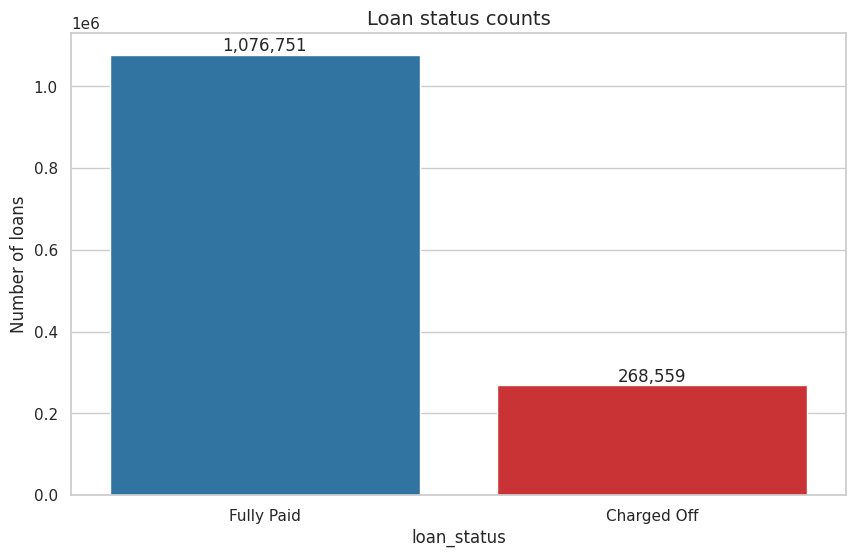

In [16]:
# 1) target variable breakdown.

target_counts = df["loan_status"].value_counts().rename_axis("loan_status").to_frame("count")
target_counts["percentage"] = (target_counts["count"] / target_counts["count"].sum() * 100).round(2)

display(target_counts)

ax = sns.barplot(
    data=target_counts.reset_index(),
    x="loan_status",
    y="count",
    hue="loan_status",
    palette=["#1f78b4", "#e31a1c"],
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="{:,.0f}")

ax.set_title("Loan status counts")
ax.set_ylabel("Number of loans")
plt.show()
plt.close()

In [17]:
# 2) missing values table.

missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
})

missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=True)

print(f"Missing Values Summary (Total rows: {len(df):,})")
display(missing_info)

Missing Values Summary (Total rows: 1,345,310)


,Missing Count,Missing Percentage
inq_last_6mths,1,0.000074
zip_code,1,0.000074
tax_liens,39,0.002899
last_credit_pull_d,55,0.004088
chargeoff_within_12_mths,56,0.004163
...,...,...
hardship_amount,1339556,99.572292
deferral_term,1339556,99.572292
orig_projected_additional_accrued_interest,1341551,99.720585
member_id,1345310,100.000000


## Correlation matrix of the top 20 numeric features

,funded_amnt,loan_amnt,funded_amnt_inv,total_acc,total_bc_limit,open_acc,num_sats,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,tot_hi_cred_lim,num_op_rev_tl,num_rev_accts,total_bal_ex_mort,acc_open_past_24mths,tot_cur_bal,total_rev_hi_lim,num_bc_sats,hardship_payoff_balance_amount
funded_amnt,1.00,1.00,1.00,0.21,0.37,0.18,0.18,0.95,0.86,0.86,0.80,0.34,0.17,0.17,0.28,0.01,0.32,0.29,0.21,0.84
loan_amnt,1.00,1.00,1.00,0.21,0.37,0.18,0.18,0.95,0.86,0.86,0.80,0.34,0.17,0.17,0.28,0.01,0.32,0.29,0.21,0.84
funded_amnt_inv,1.00,1.00,1.00,0.21,0.37,0.18,0.18,0.95,0.86,0.86,0.80,0.34,0.17,0.17,0.28,0.01,0.32,0.29,0.21,0.84
total_acc,0.21,0.21,0.21,1.00,0.28,0.70,0.70,0.18,0.18,0.18,0.18,0.33,0.56,0.76,0.43,0.43,0.31,0.26,0.39,0.15
total_bc_limit,0.37,0.37,0.37,0.28,1.00,0.36,0.36,0.34,0.33,0.33,0.36,0.40,0.42,0.36,0.28,0.06,0.31,0.65,0.60,0.28
open_acc,0.18,0.18,0.18,0.70,0.36,1.00,1.00,0.17,0.15,0.15,0.14,0.28,0.83,0.65,0.40,0.49,0.24,0.33,0.62,0.13
num_sats,0.18,0.18,0.18,0.70,0.36,1.00,1.00,0.17,0.15,0.15,0.14,0.28,0.83,0.64,0.40,0.49,0.24,0.33,0.62,0.13
installment,0.95,0.95,0.95,0.18,0.34,0.17,0.17,1.00,0.82,0.82,0.77,0.31,0.16,0.16,0.26,0.02,0.29,0.26,0.20,0.75
total_pymnt,0.86,0.86,0.86,0.18,0.33,0.15,0.15,0.82,1.00,1.00,0.97,0.32,0.14,0.15,0.24,-0.04,0.30,0.26,0.18,0.45
total_pymnt_inv,0.86,0.86,0.86,0.18,0.33,0.15,0.15,0.82,1.00,1.00,0.97,0.32,0.14,0.15,0.24,-0.04,0.30,0.26,0.18,0.45


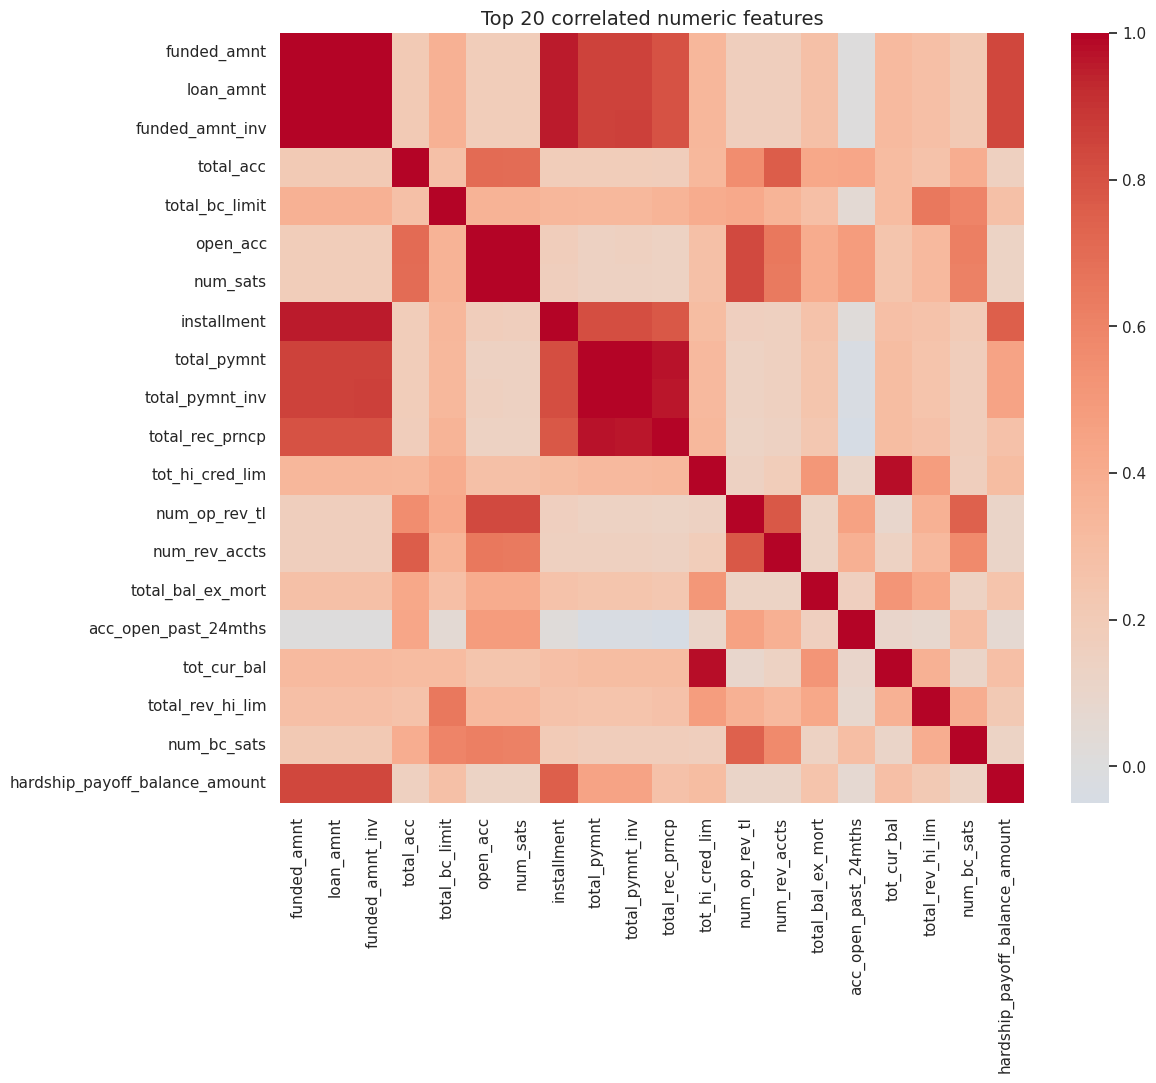

In [18]:
# 3) correlation matrix for the top 20 numeric features.

corr_matrix = numeric_sample.corr(method="pearson", min_periods=200)
corr_strength = corr_matrix.abs().sum().sort_values(ascending=False)
top_features = corr_strength.head(20).index

corr_top = corr_matrix.loc[top_features, top_features]

display(corr_top.round(2))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_top, cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 correlated numeric features")
plt.show()
plt.close()

## Top 10 features by variance

id                            1.472801e+15
tot_hi_cred_lim               3.111251e+10
tot_cur_bal                   2.469942e+10
annual_inc                    4.608817e+09
annual_inc_joint              3.629308e+09
total_bal_ex_mort             2.252383e+09
total_il_high_credit_limit    1.827890e+09
total_bal_il                  1.770282e+09
total_rev_hi_lim              1.649445e+09
revol_bal_joint               6.911912e+08
dtype: float64


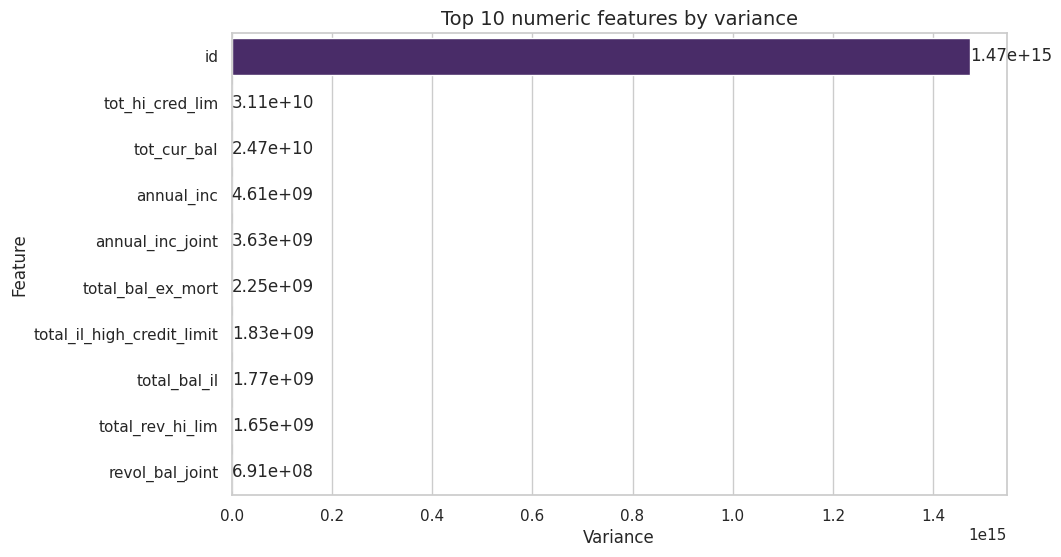

In [19]:
# 4) top 10 features by variance.

variance_series = numeric_sample.var().sort_values(ascending=False).head(10)

print(variance_series.round(2))

ax = sns.barplot(
    x=variance_series.values,
    y=variance_series.index,
    hue=variance_series.index,
    palette="viridis",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="{:.2e}")

ax.set_title("Top 10 numeric features by variance")
ax.set_xlabel("Variance")
ax.set_ylabel("Feature")
plt.show()
plt.close()

## FICO score distribution by loan status

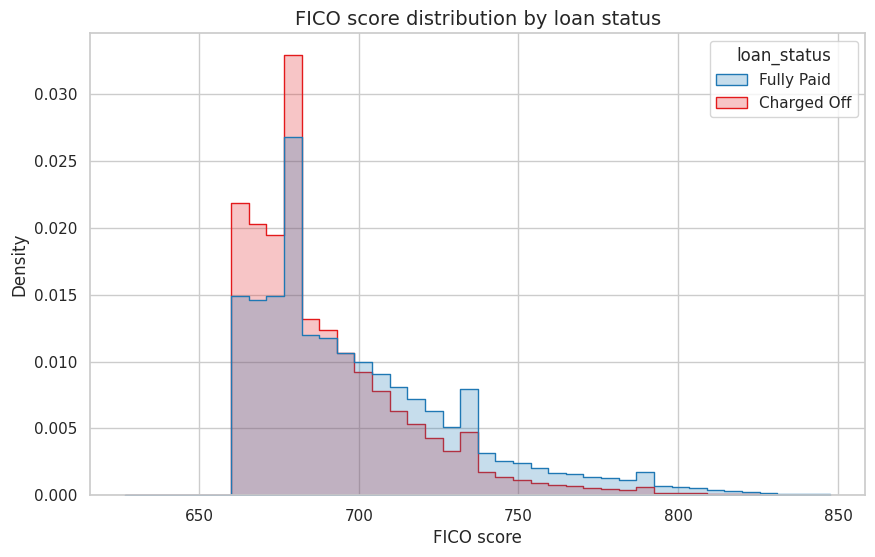

In [20]:
# 5) FICO score distribution.

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="fico_score",
    hue="loan_status",
    bins=40,
    stat="density",
    common_norm=False,
    element="step",
    fill=True,
    palette=["#1f78b4", "#e31a1c"],
)
plt.title("FICO score distribution by loan status")
plt.xlabel("FICO score")
plt.ylabel("Density")
plt.show()
plt.close()

## Interest rate distribution by loan status

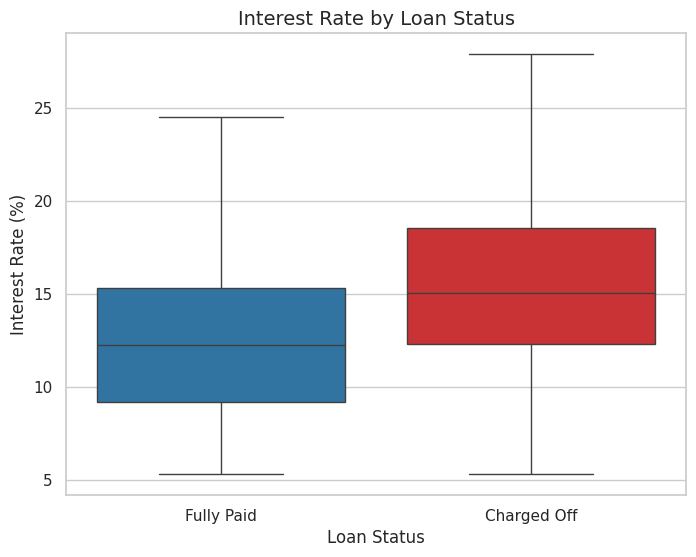

In [21]:
# 6) interest rate distribution by loan status.

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="loan_status",
    y="int_rate_num",
    hue="loan_status",
    palette=["#1f78b4", "#e31a1c"],
    showfliers=False,
    legend=False
)
plt.title("Interest Rate by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Interest Rate (%)")
plt.show()
plt.close()

## Loan size patterns

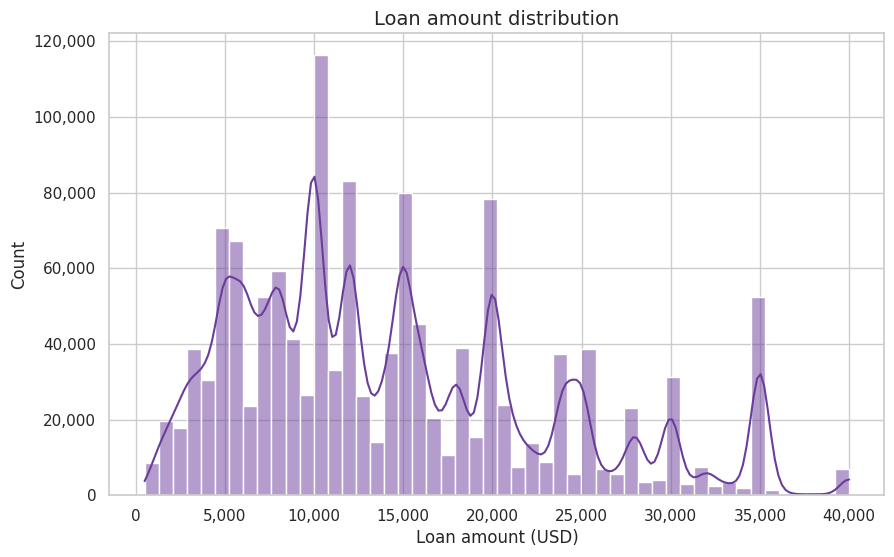

In [22]:
# 7) loan amount distribution.

import matplotlib.ticker as mticker

plt.figure(figsize=(10, 6))
ax = sns.histplot(df["loan_amnt"].dropna(), bins=50, kde=True, color="#6a3d9a")
plt.title("Loan amount distribution")
plt.xlabel("Loan amount (USD)")
plt.ylabel("Count")

# x-axis labels.
formatter = mticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)

# y-axis labels.
formatter = mticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.show()
plt.close()

## Debt-to-Income ratio distribution across loan outcomes

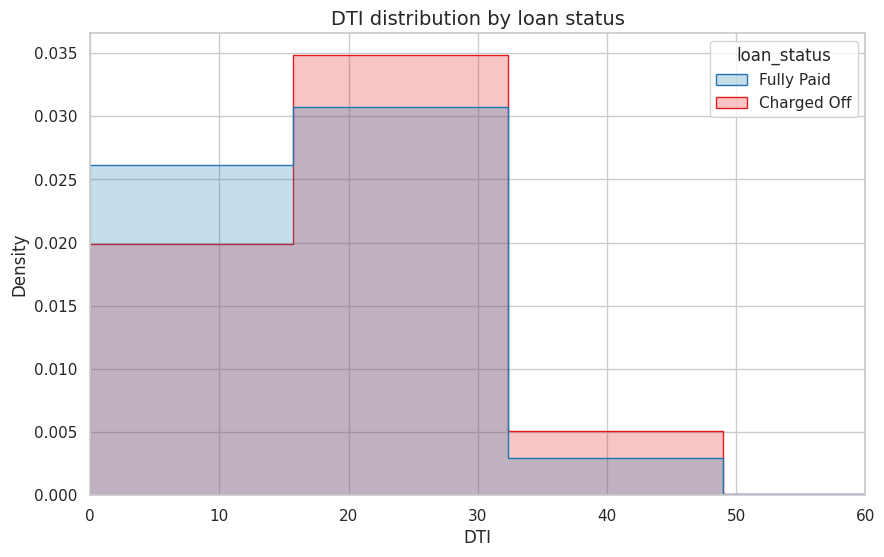

In [23]:
# 8) debt-to-income distribution by loan status.

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="dti",
    hue="loan_status",
    bins=60,
    stat="density",
    common_norm=False,
    element="step",
    fill=True,
    palette=["#1f78b4", "#e31a1c"],
)
plt.title("DTI distribution by loan status")
plt.xlabel("DTI")
plt.ylabel("Density")
plt.xlim(0, 60)
plt.show()
plt.close()

## Default rate by loan grade

,count,default_pct
grade,,
A,235090,6.04
B,392741,13.39
C,381686,22.44
D,200953,30.38
E,93650,38.48
F,32058,45.20
G,9132,49.93


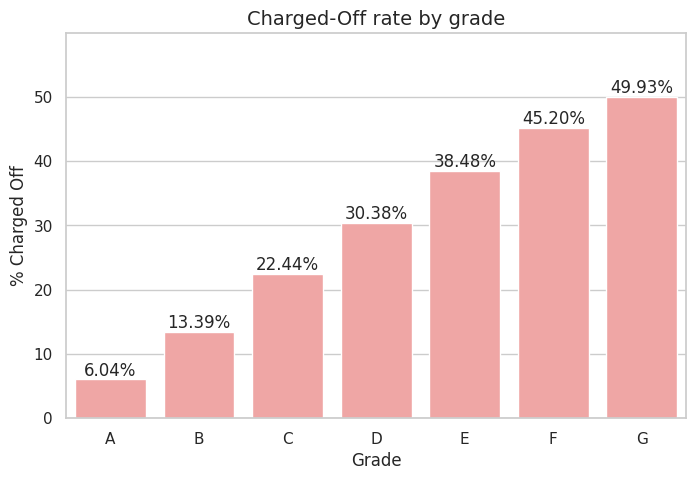

In [24]:
# 9) grade default rates.

grade_table = default_rate_table(df, "grade", min_count=1)
grade_order = [g for g in list("ABCDEFG") if g in grade_table.index]
grade_table_ordered = grade_table.loc[grade_order]

display(grade_table_ordered)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=grade_table_ordered.index,
    y=grade_table_ordered["default_pct"],
    color="#fb9a99"
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Charged-Off rate by grade")
plt.xlabel("Grade")
plt.ylabel("% Charged Off")
plt.ylim(0, grade_table_ordered["default_pct"].max() * 1.2)
plt.show()
plt.close()

## Default rate by term length

,count,default_pct
term_clean,,
60 months,324567,32.45
36 months,1020743,15.99


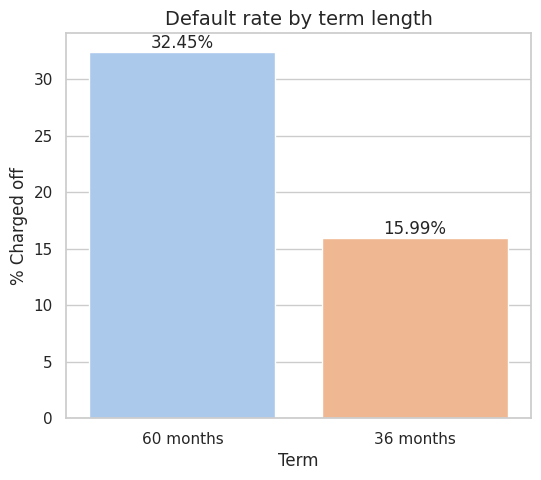

In [25]:
# 10) term length vs default.

term_table = default_rate_table(df, "term_clean", min_count=1)
term_table.index = term_table.index.str.cat([" months"] * len(term_table))
display(term_table)

plt.figure(figsize=(6, 5))
ax = sns.barplot(
    x=term_table.index,
    y=term_table["default_pct"],
    hue=term_table.index, # Assign x to hue
    palette="pastel",
    legend=False # Set legend to False as hue is for coloring
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Default rate by term length")
plt.xlabel("Term")
plt.ylabel("% Charged off")
plt.show()
plt.close()

## Default rate by employment length

,count,default_pct
emp_length_clean,,
< 1 year,108061,20.53
1 years,88494,20.56
2 years,121743,19.81
3 years,107597,19.97
4 years,80556,19.74
5 years,84154,19.60
6 years,62733,19.35
7 years,59624,19.49
8 years,60701,19.93


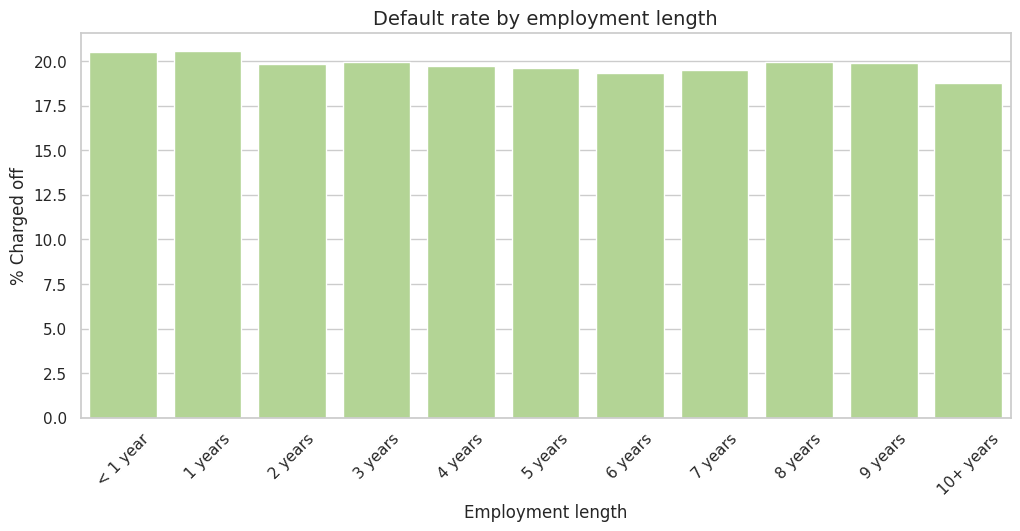

In [26]:
# 11) employment length vs default.

emp_table = default_rate_table(df, "emp_length_clean", min_count=1000)
emp_order = ["< 1 year"] + [f"{i} years" for i in range(1, 10)] + ["10+ years", "n/a"]
emp_order = [val for val in emp_order if val in emp_table.index]
emp_table = emp_table.loc[emp_order]

display(emp_table)

plt.figure(figsize=(12, 5))
sns.barplot(
    x=emp_table.index,
    y=emp_table["default_pct"],
    color="#b2df8a"
)
plt.xticks(rotation=45)
plt.title("Default rate by employment length")
plt.xlabel("Employment length")
plt.ylabel("% Charged off")
plt.show()
plt.close()

## Default rate by home ownership

,count,default_pct
home_ownership,,
RENT,534421,23.22
OWN,144832,20.62
MORTGAGE,665579,17.21


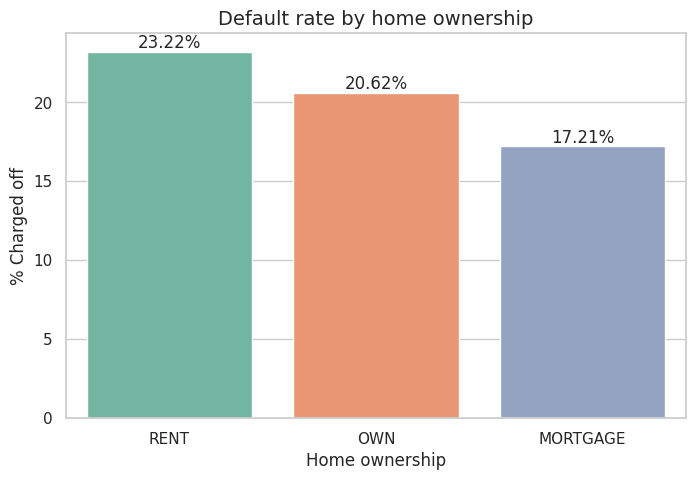

In [27]:
# 12) home ownership vs default.

home_table = default_rate_table(df, "home_ownership", min_count=1000)

display(home_table)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=home_table.index,
    y=home_table["default_pct"],
    hue=home_table.index,
    palette="Set2",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Default rate by home ownership")
plt.xlabel("Home ownership")
plt.ylabel("% Charged off")
plt.show()
plt.close()

## Distribution of revolving utilization(%)

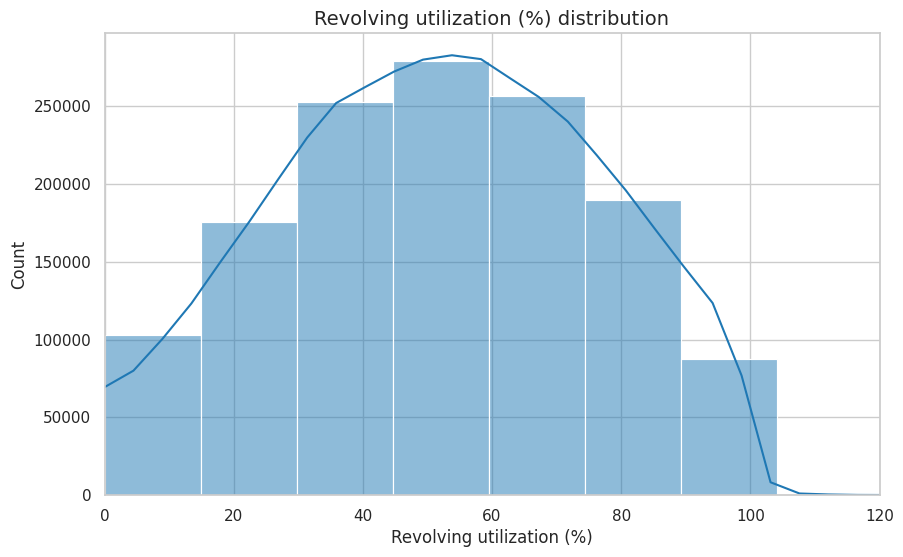

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 13) revolving utilization distribution.

plt.figure(figsize=(10, 6))
sns.histplot(df["revol_util_num"].dropna(), bins=60, kde=True, color="#1f78b4")
plt.title("Revolving utilization (%) distribution")
plt.xlabel("Revolving utilization (%)")
plt.ylabel("Count")
plt.xlim(0, 120)
plt.show()
plt.close()

## Default rate by loan purpose

,count,default_pct
purpose,,
small_business,15416,29.71
medical,15554,21.78
debt_consolidation,780321,21.15
credit_card,295279,16.93


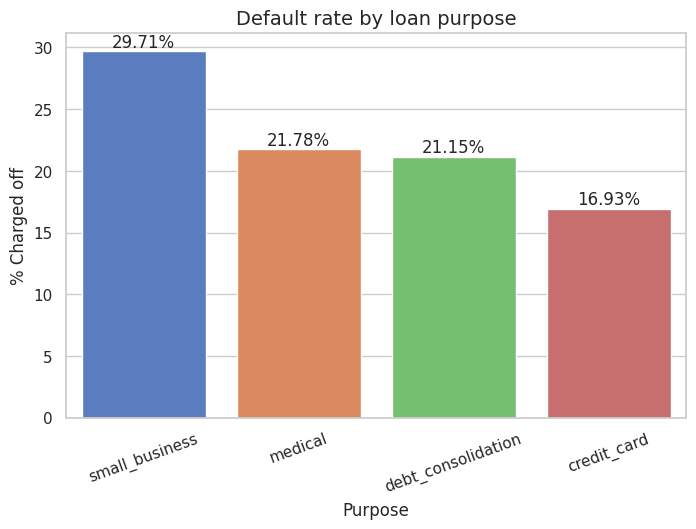

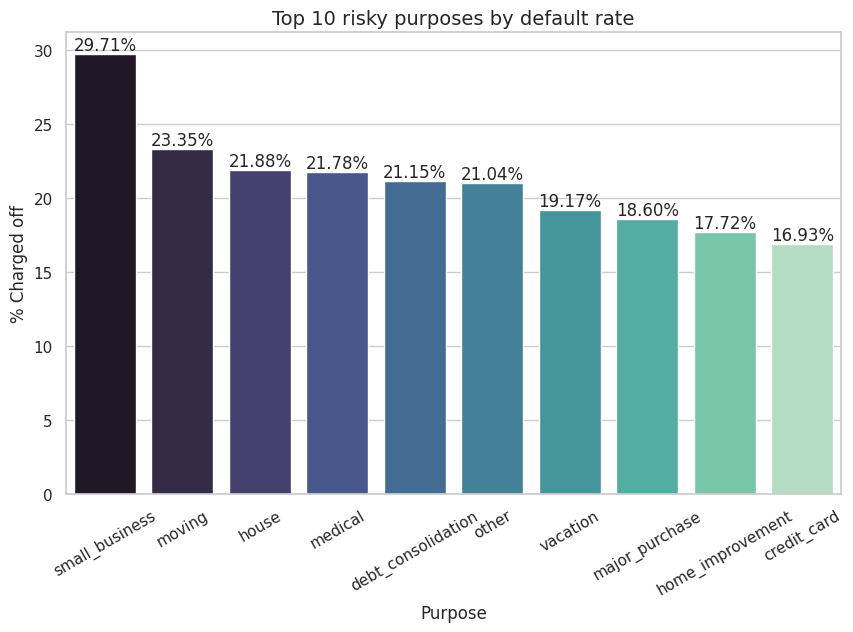

In [29]:
# 14) loan purpose default rates.

purpose_table = default_rate_table(df, "purpose", min_count=2000)
spotlight = ["debt_consolidation", "small_business", "medical", "credit_card"]
spotlight_table = purpose_table.loc[purpose_table.index.intersection(spotlight)]
# Top 10 high-risk purposes by default rate
top10_purpose = purpose_table.sort_values("default_pct", ascending=False).head(10)


if len(spotlight_table) < len(spotlight):
    missing = set(spotlight) - set(spotlight_table.index)
    print(f"Note: insufficient volume for {sorted(missing)}, so they were excluded from the bar chart.")

display(spotlight_table)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=spotlight_table.index,
    y=spotlight_table["default_pct"],
    hue=spotlight_table.index, # Assign x to hue
    palette="muted",
    legend=False # Set legend to False
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")
plt.title("Default rate by loan purpose")
plt.xlabel("Purpose")
plt.ylabel("% Charged off")
plt.xticks(rotation=20)
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top10_purpose.index,
    y=top10_purpose["default_pct"],
    hue=top10_purpose.index, # Assign x to hue
    palette="mako",
    legend=False # Set legend to False
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")
plt.title("Top 10 risky purposes by default rate")
plt.xlabel("Purpose")
plt.ylabel("% Charged off")
plt.xticks(rotation=30)
plt.show()
plt.close()

## Drift analysis of key features over time

,month_year,fico_score,dti,int_rate_num
0,2007-06,662.000000,14.290000,13.750000
1,2007-07,736.000000,7.499333,9.254667
2,2007-08,719.727273,9.772727,10.294848
3,2007-09,733.388889,7.906667,10.083889
4,2007-10,712.319149,11.220213,10.806809


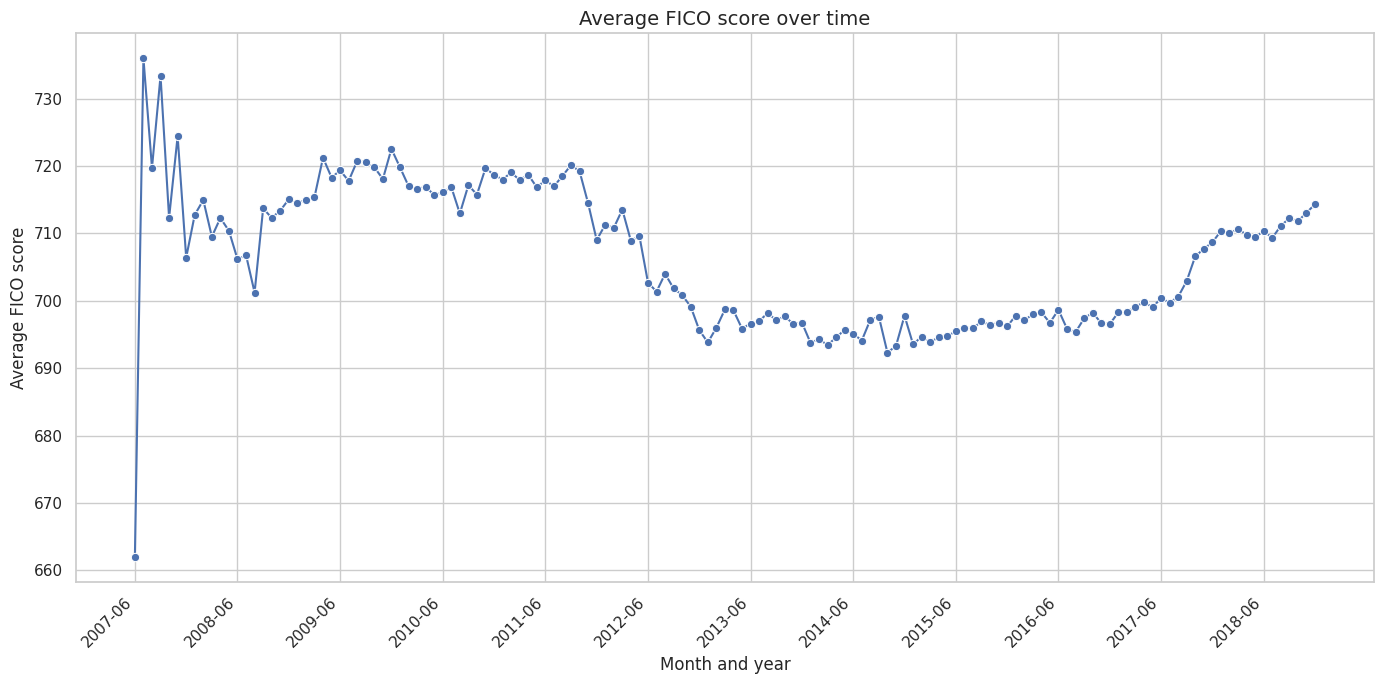

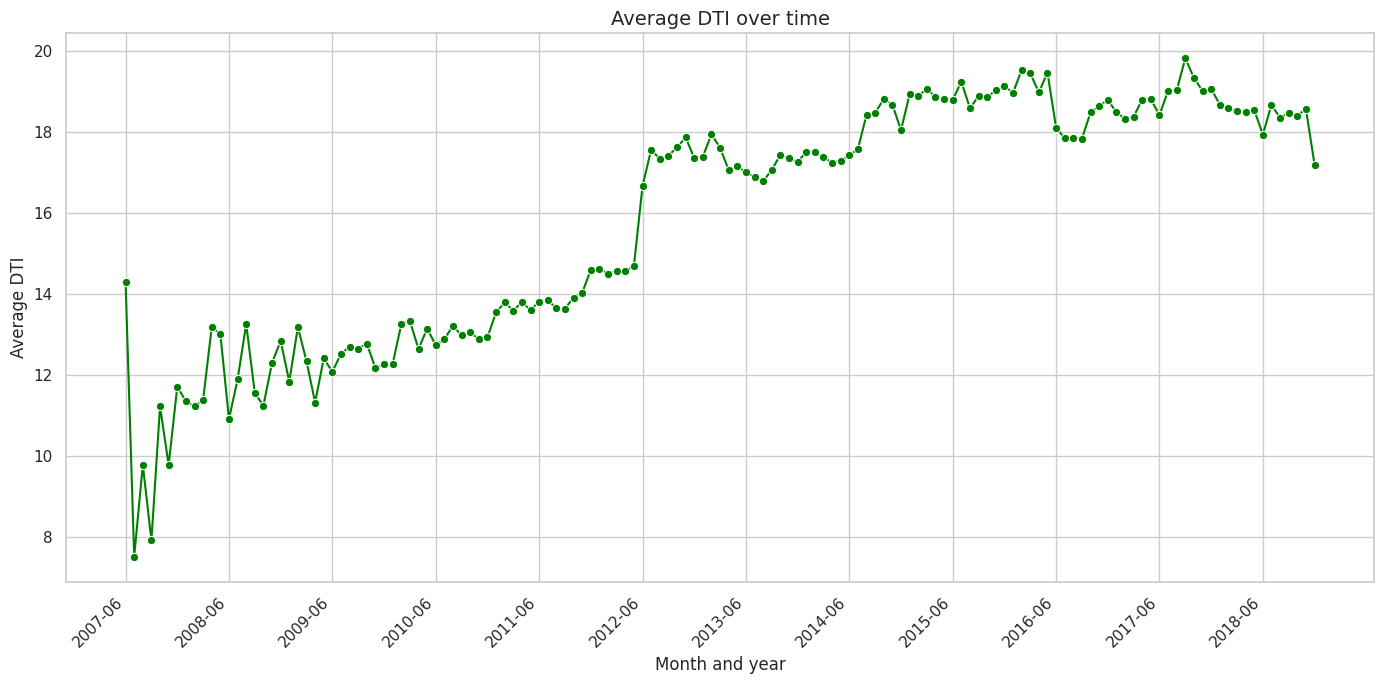

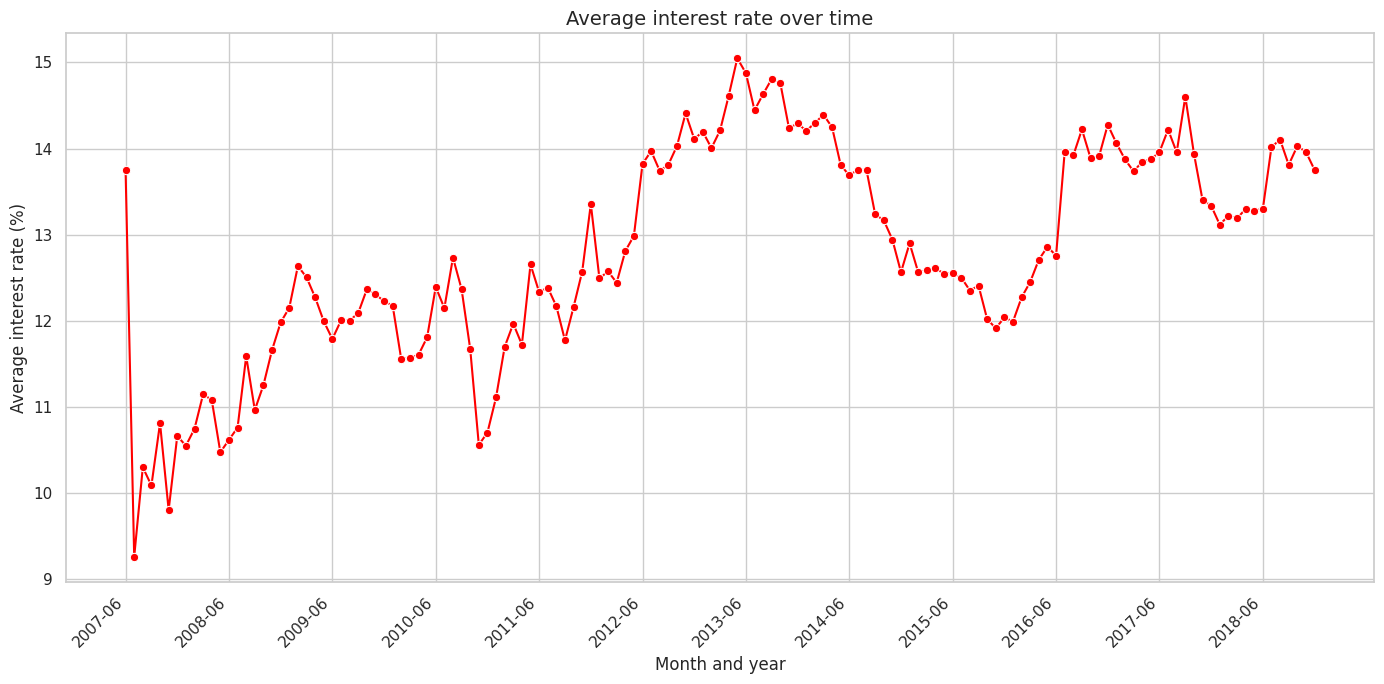

In [38]:
# 15) drift-sensitive features over time.

# checking issue_d is in datetime format and creating a month_year column
if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
    df['month_year'] = df['issue_d'].dt.to_period('M')

    # groupping by month_year and getting the mean of the drift-sensitive features/
    monthly_avg = df.groupby('month_year')[['fico_score', 'dti', 'int_rate_num']].mean().reset_index()
    monthly_avg['month_year'] = monthly_avg['month_year'].astype(str)
    monthly_avg = monthly_avg.sort_values('month_year')

    display(monthly_avg.head())

    # FICO score over time.
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_avg, x='month_year', y='fico_score', marker='o')
    plt.title('Average FICO score over time')
    plt.xlabel('Month and year')
    plt.ylabel('Average FICO score')
    n_ticks = len(monthly_avg['month_year'])
    tick_indices = range(0, n_ticks, 12)
    plt.xticks(tick_indices, [monthly_avg['month_year'].iloc[i] for i in tick_indices], rotation=45, ha='right')

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

    # DTI over time.
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_avg, x='month_year', y='dti', marker='o', color='green')
    plt.title('Average DTI over time')
    plt.xlabel('Month and year')
    plt.ylabel('Average DTI')
    n_ticks = len(monthly_avg['month_year'])
    tick_indices = range(0, n_ticks, 12)
    plt.xticks(tick_indices, [monthly_avg['month_year'].iloc[i] for i in tick_indices], rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

    # interest rate over time.
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_avg, x='month_year', y='int_rate_num', marker='o', color='red')
    plt.title('Average interest rate over time')
    plt.xlabel('Month and year')
    plt.ylabel('Average interest rate (%)')
    n_ticks = len(monthly_avg['month_year'])
    tick_indices = range(0, n_ticks, 12)
    plt.xticks(tick_indices, [monthly_avg['month_year'].iloc[i] for i in tick_indices], rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("The 'issue_d' column is not found in the DataFrame. Cannot plot time-series.")

,issue_year,fico_score,dti,int_rate_num
0,2007,717.219124,10.311076,10.315259
1,2008,711.635083,12.013387,11.155999
2,2009,719.088634,12.373170,12.189818
3,2010,716.876474,12.950827,11.748896
4,2011,716.991713,13.846331,12.223365


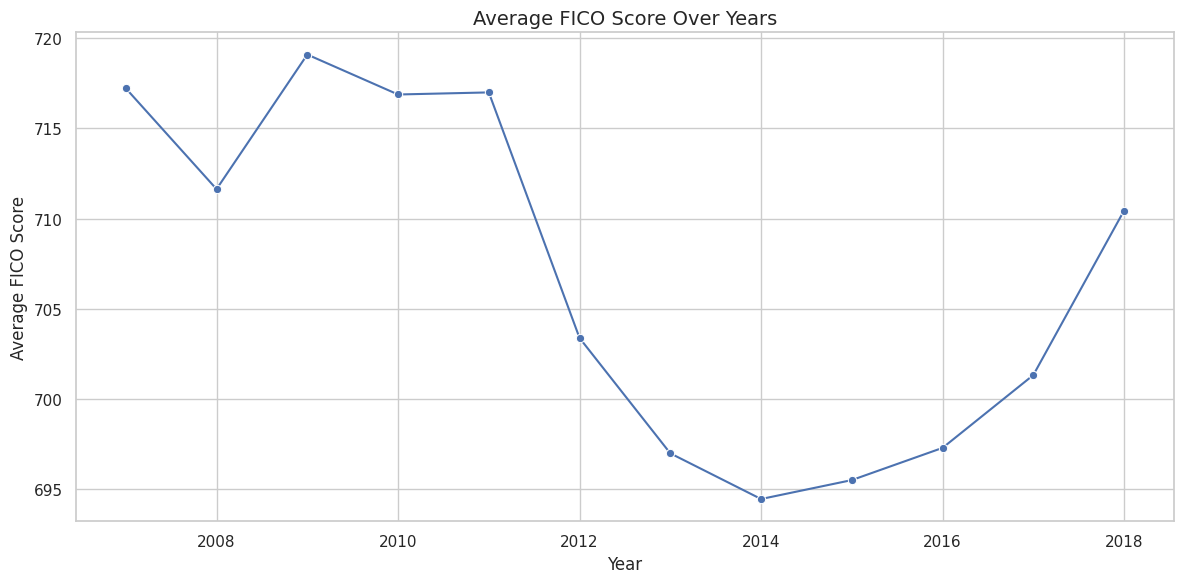

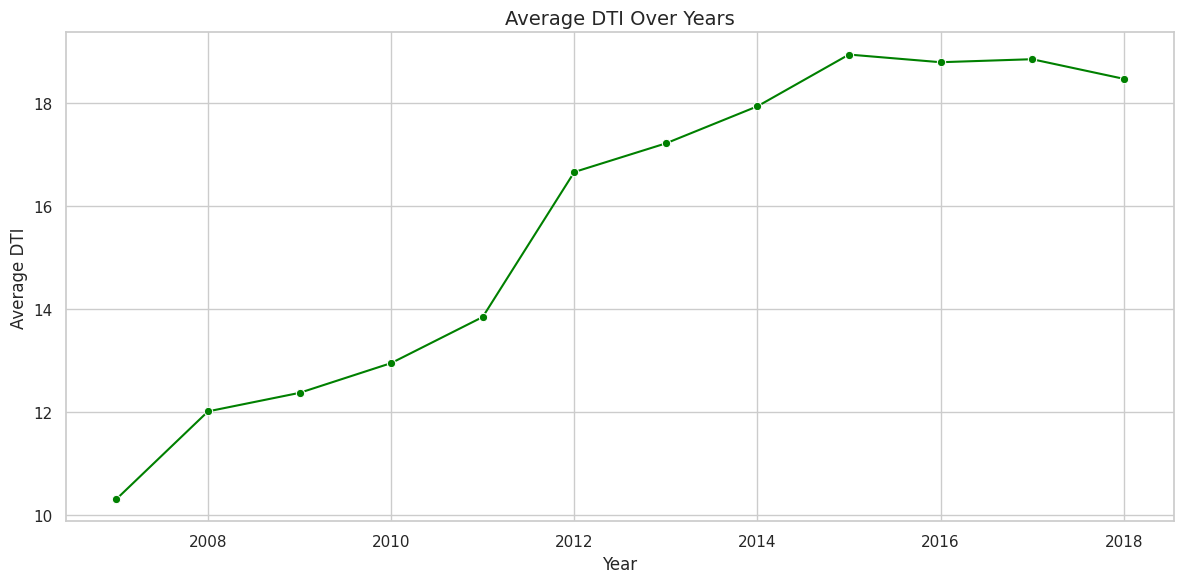

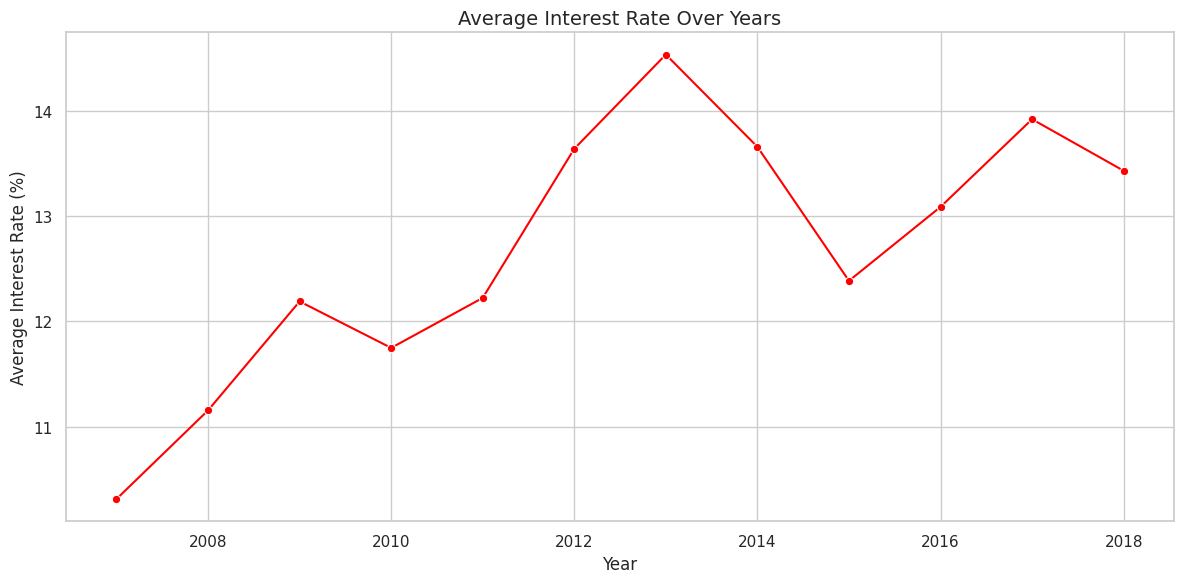

In [31]:
# 16) drift-sensitive features over time.

if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

    df['issue_year'] = df['issue_d'].dt.year

    # yearly averages of drift-sensitive features.
    yearly_avg = df.groupby('issue_year')[['fico_score', 'dti', 'int_rate_num']].mean().reset_index()

    display(yearly_avg.head())


    # FICO score yearly trend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_avg, x='issue_year', y='fico_score', marker='o')
    plt.title('Average FICO score over years')
    plt.xlabel('Year')
    plt.ylabel('Average FICO score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()


    # DTI yearly trend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_avg, x='issue_year', y='dti', marker='o', color='green')
    plt.title('Average DTI over years')
    plt.xlabel('Year')
    plt.ylabel('Average DTI')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()


    # Interest rate yearly trend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_avg, x='issue_year', y='int_rate_num', marker='o', color='red')
    plt.title('Average interest rate over years')
    plt.xlabel('Year')
    plt.ylabel('Average interest rate (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

else:
    print("The 'issue_d' column is not found in the DataFrame. Cannot plot time-series.")


## Yearly trends from date features

In [32]:
# 16) datetime features.
if 'issue_d' in df.columns:
    df['issue_year'] = df['issue_d'].dt.year

    # groupping by issue_year.
    yearly_trends = df.groupby('issue_year').agg(
        default_rate=('is_default', 'mean'),
        avg_loan_amnt=('loan_amnt', 'mean'),
        avg_int_rate=('int_rate_num', 'mean')
    ).reset_index()

    display(yearly_trends)

,issue_year,default_rate,avg_loan_amnt,avg_int_rate
0,2007,0.179283,8841.733068,10.315259
1,2008,0.158131,9212.724072,11.155999
2,2009,0.125954,9846.548982,12.189818
3,2010,0.128901,10586.095700,11.748896
4,2011,0.151789,12047.503568,12.223365
5,2012,0.161973,13461.709015,13.637787
6,2013,0.155960,14707.375152,14.531628
7,2014,0.184494,14582.914990,13.656295
8,2015,0.201848,14641.563994,12.385183
9,2016,0.232832,14467.135741,13.086578


## Top 10 features most correlated with loan default

,Correlation with is_default
recoveries,0.505415
collection_recovery_fee,0.480216
int_rate,0.258792
int_rate_num,0.258792
total_pymnt_inv,-0.314751
total_pymnt,-0.315180
last_pymnt_amnt,-0.347385
total_rec_prncp,-0.438944
last_fico_range_low,-0.575706
last_fico_range_high,-0.667842


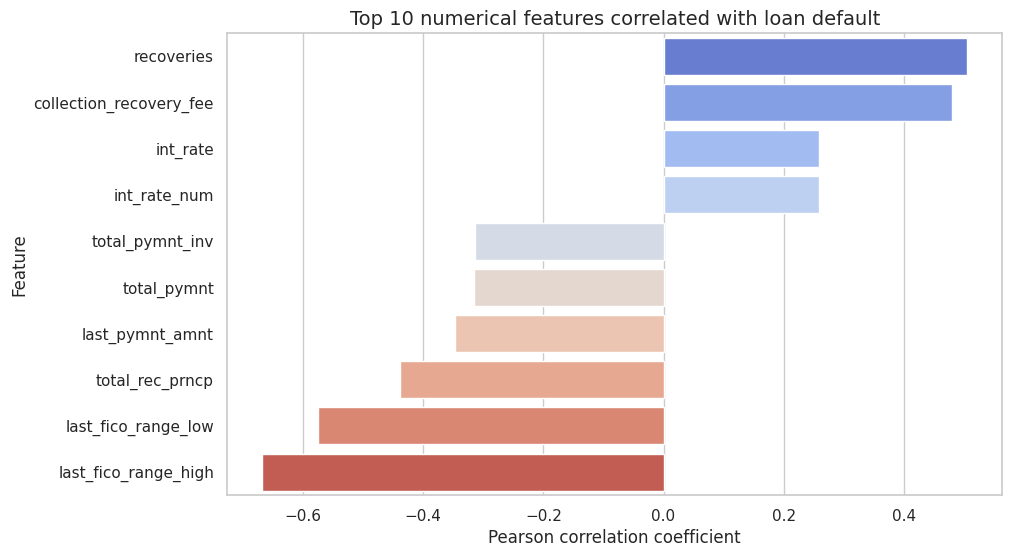

In [33]:
# 18) correlation with the target variable.

# correlations with the target variable.
correlations = df.select_dtypes(include=[np.number]).corr(method='pearson')['is_default'].drop('is_default')

# top 10 most correlated features by absolute value.
top_10_corr = correlations.abs().sort_values(ascending=False).head(10).index
corr_with_target = correlations.loc[top_10_corr].sort_values(ascending=False)

display(corr_with_target.to_frame(name='Correlation with is_default'))

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, hue=corr_with_target.index, palette='coolwarm', legend=False)
plt.title('Top 10 numerical features correlated with loan default')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Feature')
plt.show()
plt.close()